# An introduction to the Session object

This is a quick notebook showing off the Sherpa session API. This is the code that makes the UI layer (either `sherpa.astro.ui` or `sherpa.ui`) work, but in these modules it is hidden away.

I am using the Sherpa 4.9.0 release (which is being released as I type this), having used conda to install it
with an invocation like

    conda create -n=sherpa-standalone-notebooks -c sherpa python=3.5 sherpa astropy matplotlib ipython-notebook
    
This picked up version 2.0.0 of matplotlib; it will be interesting to see how the changes to the default plot
styling work in Sherpa (we have an 
[open issue about this](https://github.com/sherpa/sherpa/issues/224)).

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on January 31 2017. This notebook, and others that may be of interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository or on Twitter - at 
[@doug_burke](https://twitter.com/doug_burke) - if you have any questions.

## Last run

Let's start off by seeing when I last ran this notebook

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2017-01-31 16:34'

and what version of Sherpa is being used (the 'full' key represents the git commit used to build this version of Sherpa):

In [2]:
import sherpa
print(sherpa._version.get_versions())

{'version': '4.9.0', 'full': '8638ca0fe411693ea3b1eebe0df47512ec5bd542'}


## What is the Session object for?

The Session object provides the state management code used by the UI layer; that is either of the `sherpa.ui` or `sherpa.astro.ui` modules. It is hidden away by these modules, but can be used directly, as shown below. This is useful if you want a (slightly) more Pythonic interface or need to encapsulate your fits, but do not want to use the
lower-level object-oriented API I've described in some of
[my other Sherpa notebooks](https://github.com/DougBurke/sherpa-standalone-notebooks).

## What data is going to be fit?

For this example I'm just going to simulate a simple data set, an off-center one-dimensional gaussian:

In [3]:
import numpy as np
%matplotlib inline

In [4]:
np.random.seed(0)
x = np.linspace(-5., 5., 200)
ampl_true = 3
pos_true = 1.3
sigma_true = 0.8
err_true = 0.2
y = ampl_true * np.exp(-0.5 * (x - pos_true)**2 / sigma_true**2)
y += np.random.normal(0., err_true, x.shape)

## What does this look like?

I could plot this directly with matplotlib, but as this notebook is all about the Session object, let's start using it. Here I use the basic version, but I could have also said

    from sherpa.astro.ui.utils import Session

In [5]:
from sherpa.ui.utils import Session
s = Session()
print(s)

The Session object implements the API used by the `sherpa.ui` and `sherpa.astro.ui` modules, so the approach I am going to take is to call `s.some_long_method_name()` when I previously would have used `ui.some_long_method_name()` (or, 
`some_long_method_name()` if you've been looking at the
[CIAO documentation for Sherpa](http://cxc.harvard.edu/sherpa/), which imports everything into the default namespace).

Using this, I can create a data set and plot it:

In [6]:
s.load_arrays(1, x, y)
print(s.get_data())

name      = 
x         = Float64[200]
y         = Float64[200]
staterror = None
syserror  = None


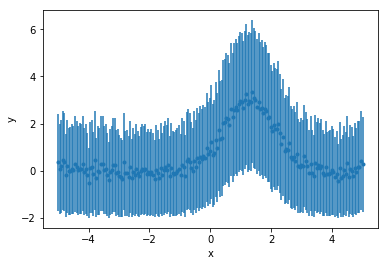

In [7]:
s.plot_data()

Let's get rid of the error bars and try again.

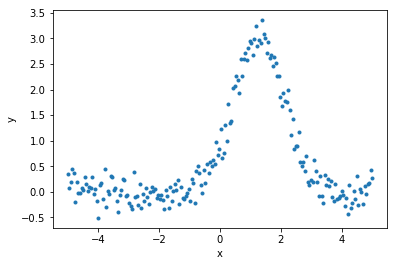

In [8]:
s.get_data_plot_prefs()['yerrorbars'] = False
s.plot_data()

That's a bit better, although I'd prefer the plot to be a bit bigger. Oh well, that can wait for another notebook.

Creating a model component to fit to the data would - using the UI layer, look something like

    ui.set_source(ui.gauss1d.gmdl)
    
It seems to be a bit-more complicated with the session object; the following is my best guess 
(I am just dropping down to use the object layer) but there may be a better way.

In [9]:
from sherpa.models.basic import Gauss1D

gmdl = Gauss1D('gmdl')
print(gmdl)

gmdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gmdl.fwhm    thawed           10  1.17549e-38  3.40282e+38           
   gmdl.pos     thawed            0 -3.40282e+38  3.40282e+38           
   gmdl.ampl    thawed            1 -3.40282e+38  3.40282e+38           


In [10]:
s.set_source(gmdl)

As shown below, the default parameters for the gaussian are not a good match to the data:

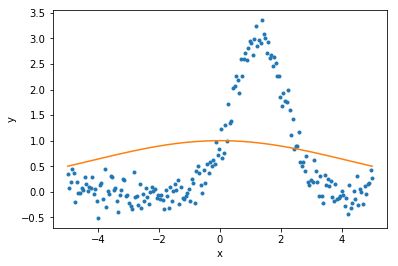

In [11]:
s.plot_fit()

How well does the guess routine do?

gmdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gmdl.fwhm    thawed      2.21106   0.00221106      2211.06           
   gmdl.pos     thawed      1.38191           -5            5           
   gmdl.ampl    thawed      3.35417   0.00335417      3354.17           


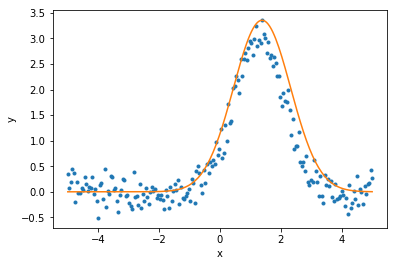

In [12]:
s.guess(gmdl)
print(gmdl)
s.plot_fit()

Well, that's embarassing: my "really hard to fit" dataset has almost been fit just by some simple heuristics! Oh well, at least it'll mean the notebook will run quickly!

To fit the model I want to choose a statistic - in this case, as I don't have meaningful errors, I am just going to go for least-squares minimisation

In [13]:
s.set_stat('leastsq')

and an optimiser (which I am going to leave at the default value, which is Levenberg-Marquardt):

In [14]:
print(s.get_method())

name    = levmar
ftol    = 1.19209289551e-07
xtol    = 1.19209289551e-07
gtol    = 1.19209289551e-07
maxfev  = None
epsfcn  = 1.19209289551e-07
factor  = 100.0
verbose = 0


After this, I can call the `fit` method on the Session object to get a fit:

In [15]:
s.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 22.6495
Final fit statistic   = 8.06975 at function evaluation 17
Data points           = 200
Degrees of freedom    = 197
Change in statistic   = 14.5797
   gmdl.fwhm      1.91572     
   gmdl.pos       1.2743      
   gmdl.ampl      3.04706     


The results can be retrieved programatically, as shown below:

In [16]:
res = s.get_fit_results()
print(res)

datasets       = (1,)
itermethodname = none
methodname     = levmar
statname       = leastsq
succeeded      = True
parnames       = ('gmdl.fwhm', 'gmdl.pos', 'gmdl.ampl')
parvals        = (1.91572309594081, 1.2743013821131373, 3.0470568279585759)
statval        = 8.069746329904383
istatval       = 22.649479944641005
dstatval       = 14.5797336147
numpoints      = 200
dof            = 197
qval           = None
rstat          = None
message        = successful termination
nfev           = 17


Let's see how it looks:

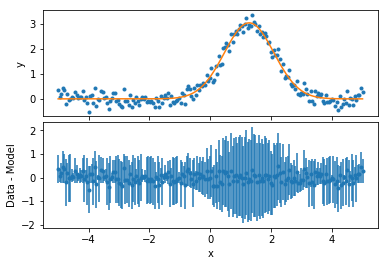

In [17]:
s.plot_fit_resid()

There's unfortunately no easy way to turn off the error bars in the residual plot. I really should put in an issue about this.

Hopefully this shows that you can just use the Session object to access the methods from the UI layer. Extending this example, we could ignore part of the data:

In [18]:
print("Statistic for all the data:     {}".format(s.calc_stat()))

s.ignore(-0.5, 0.7)

print("Statistic for some of the data: {}".format(s.calc_stat()))

Statistic for all the data:     8.069746329904383
Statistic for some of the data: 6.923035681103131


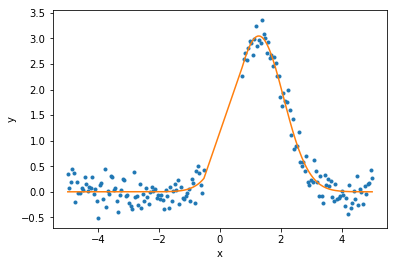

In [19]:
s.plot_fit()

Given that the data has changed, we can re-fit the model, but the difference is not large:

In [20]:
s.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 6.92304
Final fit statistic   = 6.91976 at function evaluation 13
Data points           = 176
Degrees of freedom    = 173
Change in statistic   = 0.0032799
   gmdl.fwhm      1.90815     
   gmdl.pos       1.28033     
   gmdl.ampl      3.04076     


We can create a separate, completely independent, session (note that the sessions created by `sherpa.ui.utils.Session` and `sherpa.astro.ui.utils.Session` are also different):

In [21]:
s2 = Session()
print("Session 1 data: {}".format(s.list_data_ids()))
print("        2     : {}".format(s2.list_data_ids()))

Session 1 data: [1]
        2     : []


Changes to this new object do not affect the original session (unless you change any shared state, such as the model components):

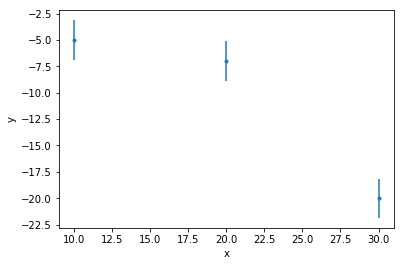

In [22]:
s2.load_arrays(1, [10, 20, 30], [-5, -7, -20])

s2.plot_data()

The original data is still present, as shown in the plot below.

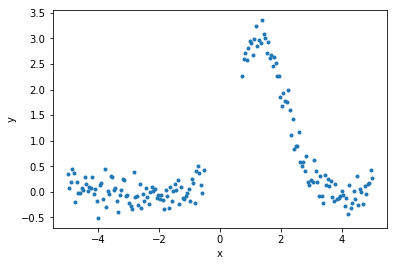

In [23]:
s.plot_data()

You can even overplot the data from the two sessions (although in this case it's not very illuminating, given that both data sets are fictitious): 

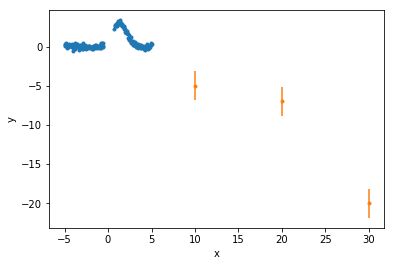

In [24]:
s.plot_data()
s2.plot_data(overplot=True)

Other choices - such as plot options (e.g. the lack of error bars for the original data) or choice of statistic (as shown below), are also stored in the session object.

In [25]:
print("Statistic choice: {} vs {}".format(s.get_stat_name(), s2.get_stat_name()))

Statistic choice: leastsq vs chi2gehrels


I have run out of simple things to run through here, but hopefully it has provided a starter for anyone who wants the convenience of the data management provided by the Sherpa UI layer but wants a bit-more control.